<a href="https://colab.research.google.com/github/aaron-v19/mlprojects/blob/main/Beatrice_ttm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [3]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

fatal: destination path 'tsfm' already exists and is not an empty directory.


In [4]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [5]:
# Do ls
! ls

build	 Makefile   pyproject.toml  scripts   tests  tsfmhfdemos  tsfm_public.egg-info
LICENSE  notebooks  README.md	    services  tsfm   tsfm_public  wiki.md


In [6]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.19.dev7+g397c895-py3-none-any.whl size=2338172 sha256=48dadf0dd0d8568ff844db1da5490a25d0cc04e9049297441fafbc89b788375e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzf8r_mt/wheels/b0/e9/d5/46ac6e5f659a03cfc8e396b992ac1b7e0c0bd1e34c7f5fe8e4
Successfully built tsfm_public
  Attempting uninstall: tsfm_public
    Found existing installation: tsfm_public 0.2.19.dev7+g397c895
    Uninstalling tsfm_public-0.2.19.dev7+g397c895:
      Successfully uninstalled tsfm_public-0.2.19.dev7+g397c895


Import Libraries

In [7]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd




# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

2025-01-31 10:18:53.511956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738318733.568211    8926 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738318733.588637    8926 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 10:18:53.651839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# First Party
from tsfm_public import count_parameters

from tsfm_public.toolkit.visualization import plot_predictions as plot_preds

#Important Arguments

In [9]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "beatrice"
DATA_ROOT_PATH = "/content/drive/MyDrive/Windmill project/Beatrice.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

#Get data

In [19]:
# Load the data file and see the columns
data = pd.read_csv(DATA_ROOT_PATH)
data['time'] = pd.to_datetime(data['time'], format='%d-%m-%Y %H:%M')
data

,Unnamed: 0,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power_of_SWT-7.0-154,Turn_off,Power
0,0,1980-01-01 00:00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800,1,378.95800
1,1,1980-01-01 01:00:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520,1,390.87520
2,2,1980-01-01 02:00:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732,1,379.56732
3,3,1980-01-01 03:00:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005,1,376.18005
4,4,1980-01-01 04:00:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446,1,406.82446
...,...,...,...,...,...,...,...,...,...,...,...
350635,350635,2019-12-31 19:00:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489,1,176.63489
350636,350636,2019-12-31 20:00:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825,1,156.59825
350637,350637,2019-12-31 21:00:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127,1,162.77127
350638,350638,2019-12-31 22:00:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679,1,140.61679


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Unnamed: 0                 350640 non-null  int64         
 1   time                       350640 non-null  datetime64[ns]
 2   u100                       350640 non-null  float64       
 3   v100                       350640 non-null  float64       
 4   fsr                        350640 non-null  float64       
 5   Windspeed                  350640 non-null  float64       
 6   Scaled_Windspeed_(at_90m)  350640 non-null  float64       
 7   Wind_Direction             350640 non-null  float64       
 8   Power_of_SWT-7.0-154       350640 non-null  float64       
 9   Turn_off                   350640 non-null  int64         
 10  Power                      350640 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory us

<Axes: xlabel='time'>

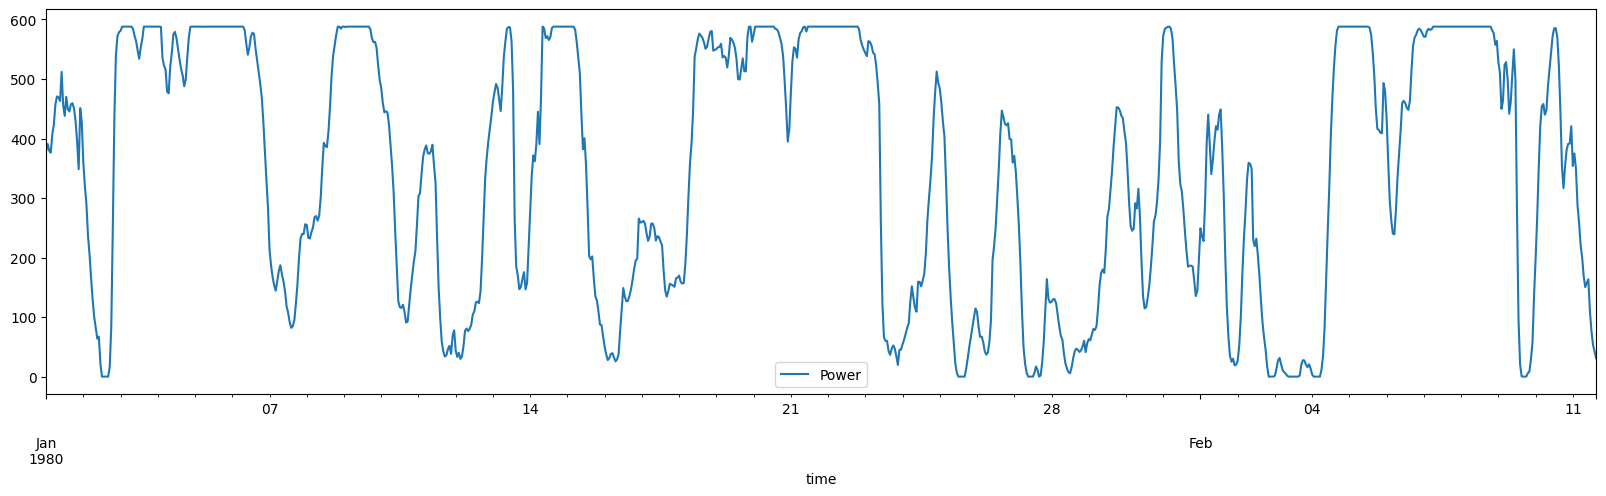

In [21]:
data.iloc[:1000].plot(x="time", y="Power", figsize=(20,5))

#Initial Cleaning


So we see that there is no power generated when Turn_off=0 and also Power_of_SWT-7.0-154 is same as Power.

Then we can drop following Columns and row without affecting our results

1. Unnamed:0
2. Power_of_SWT-7.0-154
3. Turn_off (After removing rows containing 0 as value)

In [22]:
# Drop Row containg Turn_off value=0
data=data[data['Turn_off'] !=0]
data['Turn_off'].value_counts()

,count
Turn_off,
1,350388


In [23]:
# Drop Columns
cols_to_drop=['Power_of_SWT-7.0-154','Unnamed: 0','Turn_off']
data.drop(columns=cols_to_drop,inplace=True)

/tmp/ipykernel_8926/3755548803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=cols_to_drop,inplace=True)


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350388 entries, 0 to 350639
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       350388 non-null  datetime64[ns]
 1   u100                       350388 non-null  float64       
 2   v100                       350388 non-null  float64       
 3   fsr                        350388 non-null  float64       
 4   Windspeed                  350388 non-null  float64       
 5   Scaled_Windspeed_(at_90m)  350388 non-null  float64       
 6   Wind_Direction             350388 non-null  float64       
 7   Power                      350388 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 24.1 MB


# Data Processing Pipeline

In [25]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = DATA_ROOT_PATH
timestamp_column = "time"
id_columns = []
target_columns = 'Power'
split_config = {
                "train": [0, 12 * 30 * 24 * 4],
                "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
                "test": [
                    12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
                    12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
                ],
            }
# Understanding the split config -- slides

#data = pd.read_csv(dataset_path,parse_dates=[timestamp_column],)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [
        'u100',
        'v100',
        'fsr',
        'Windspeed',
        'Scaled_Windspeed_(at_90m)',
        'Wind_Direction'
    ],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

/tmp/ipykernel_8926/3331934318.py:35: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 1607, val = 11425, test = 11425


In [26]:
train_dataset[3]

{'past_values': tensor([[ 0.0357, -1.5742, -0.1609,  ...,  0.1458, -1.1143,  0.3144],
         [ 0.0959, -1.6076, -0.1241,  ...,  0.2220, -1.0926,  0.4511],
         [ 0.1225, -1.6277, -0.0668,  ...,  0.2649, -1.0842,  0.5265],
         ...,
         [-3.0422, -0.3003,  0.7431,  ...,  2.1721, -2.2484,  1.2593],
         [-3.0021, -0.4013,  0.7032,  ...,  2.1172, -2.2229,  1.2593],
         [-3.2437, -0.1431,  1.0621,  ...,  2.4878,  1.7418,  1.2593]]),
 'future_values': tensor([[-3.1320e+00, -1.4574e-01,  9.7560e-01,  2.3135e+00,  2.3135e+00,
           1.7416e+00,  1.2593e+00],
         [-2.8724e+00, -2.9802e-01,  5.4475e-01,  1.9071e+00,  1.9071e+00,
          -2.2479e+00,  1.2593e+00],
         [-2.7540e+00, -3.7700e-01,  3.3092e-01,  1.7281e+00,  1.7281e+00,
          -2.2254e+00,  1.2593e+00],
         [-2.6686e+00, -4.7193e-01,  2.3529e-01,  1.6082e+00,  1.6083e+00,
          -2.1971e+00,  1.2593e+00],
         [-2.6290e+00, -5.7057e-01,  1.9143e-01,  1.5677e+00,  1.5677e+00,
   

#Zero-shot evaluation method

In [27]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
zeroshot_model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [28]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [33]:
import wandb

wandb.login(key="30426370ccf0c5477118a427f0bed8eb18e5f832") # Replace YOUR_API_KEY
# Initialize wandb before evaluating
wandb.init(project="Beatrice_ttm", name="test run")  # Replace with your project and run names


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [34]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.8814178109169006,
 'eval_model_preparation_time': 0.0045,
 'eval_runtime': 9.9205,
 'eval_samples_per_second': 1151.655,
 'eval_steps_per_second': 18.043}

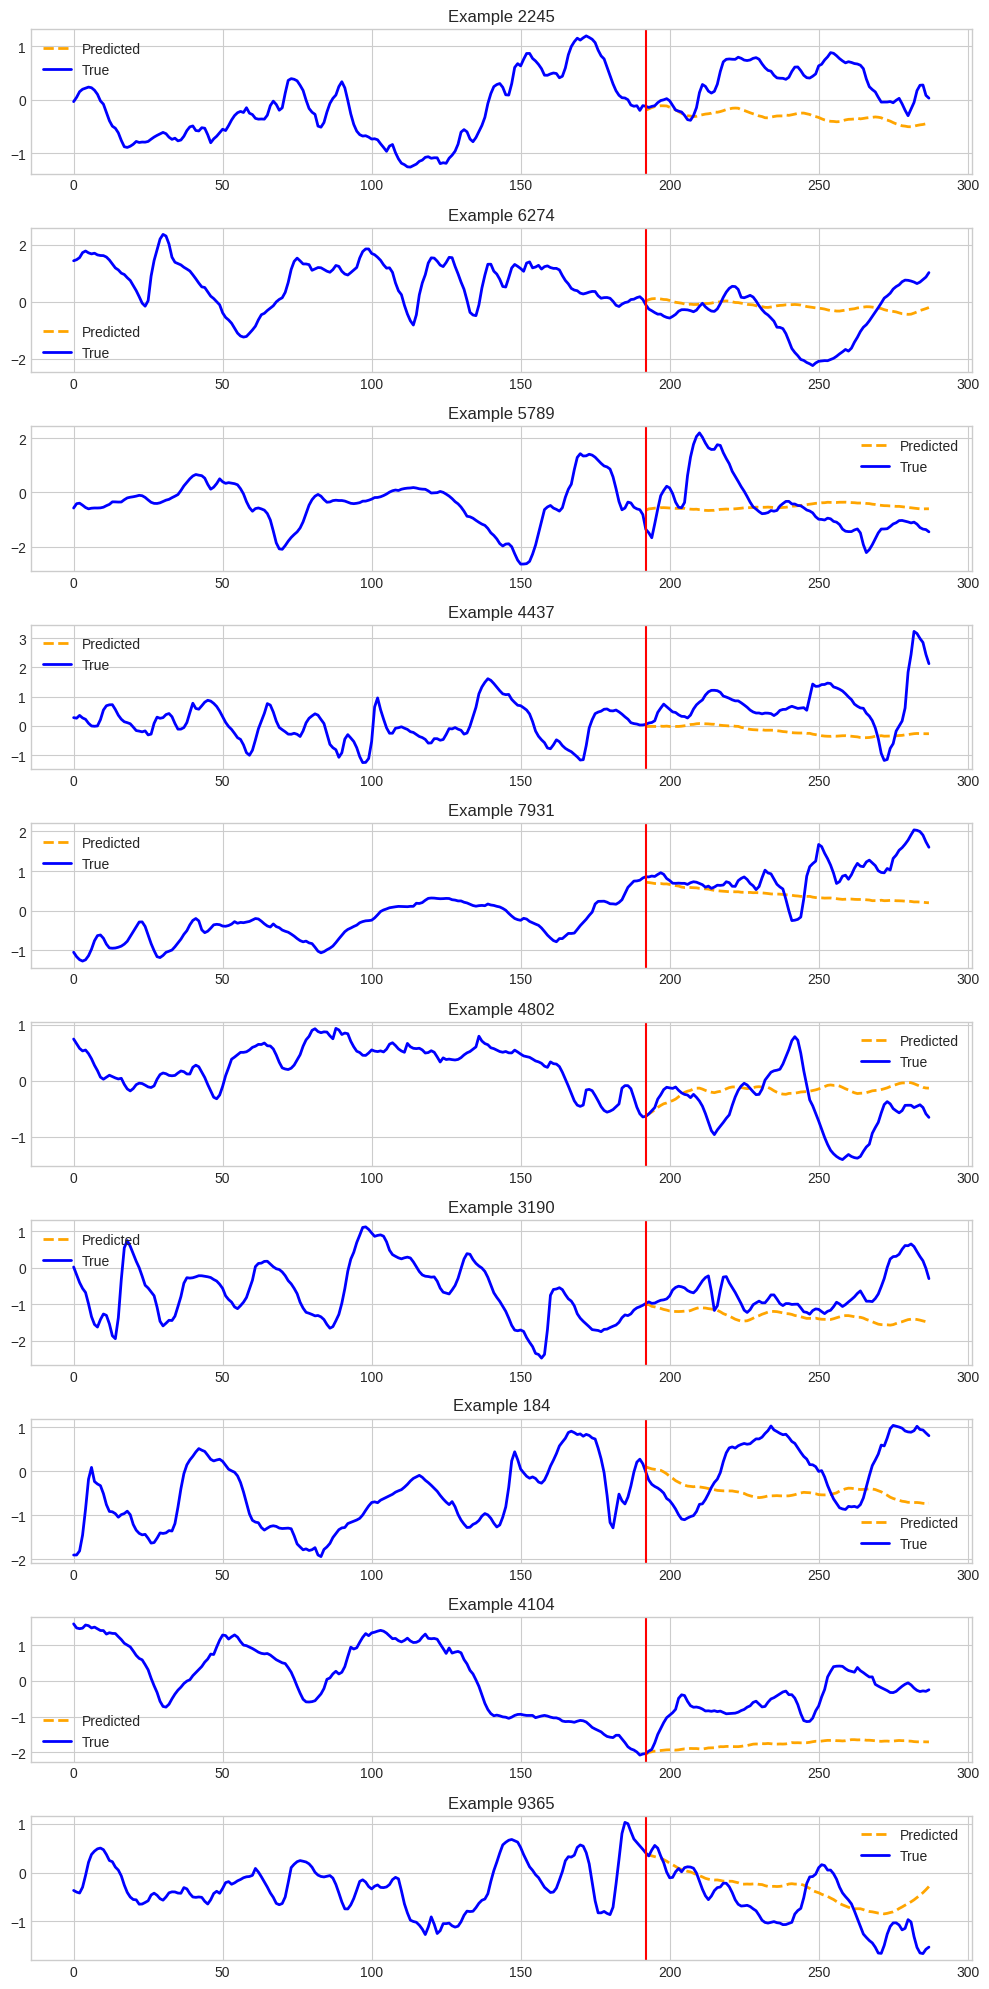

In [59]:
# plot
from tsfm_public.toolkit.visualization import plot_predictions
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_zeroshot",
    channel=0,
)

# Few-Shot evaluation model

In [61]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

###Freeze the TTM backbone

In [62]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


## Fine tune few-shot 5%

In [63]:
# Important parameters
learning_rate = 0.001
num_epochs = 1 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [64]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.425700,0.872493


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[TrackingCallback] Mean Epoch Time = 2.2156643867492676 seconds, Total Train Time = 7.007845640182495


TrainOutput(global_step=26, training_loss=1.425664021418645, metrics={'train_runtime': 7.0188, 'train_samples_per_second': 228.957, 'train_steps_per_second': 3.704, 'total_flos': 27828002979840.0, 'train_loss': 1.425664021418645, 'epoch': 1.0})

In [65]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 0.8152921795845032,
 'eval_runtime': 10.2032,
 'eval_samples_per_second': 1119.752,
 'eval_steps_per_second': 17.544,
 'epoch': 1.0}

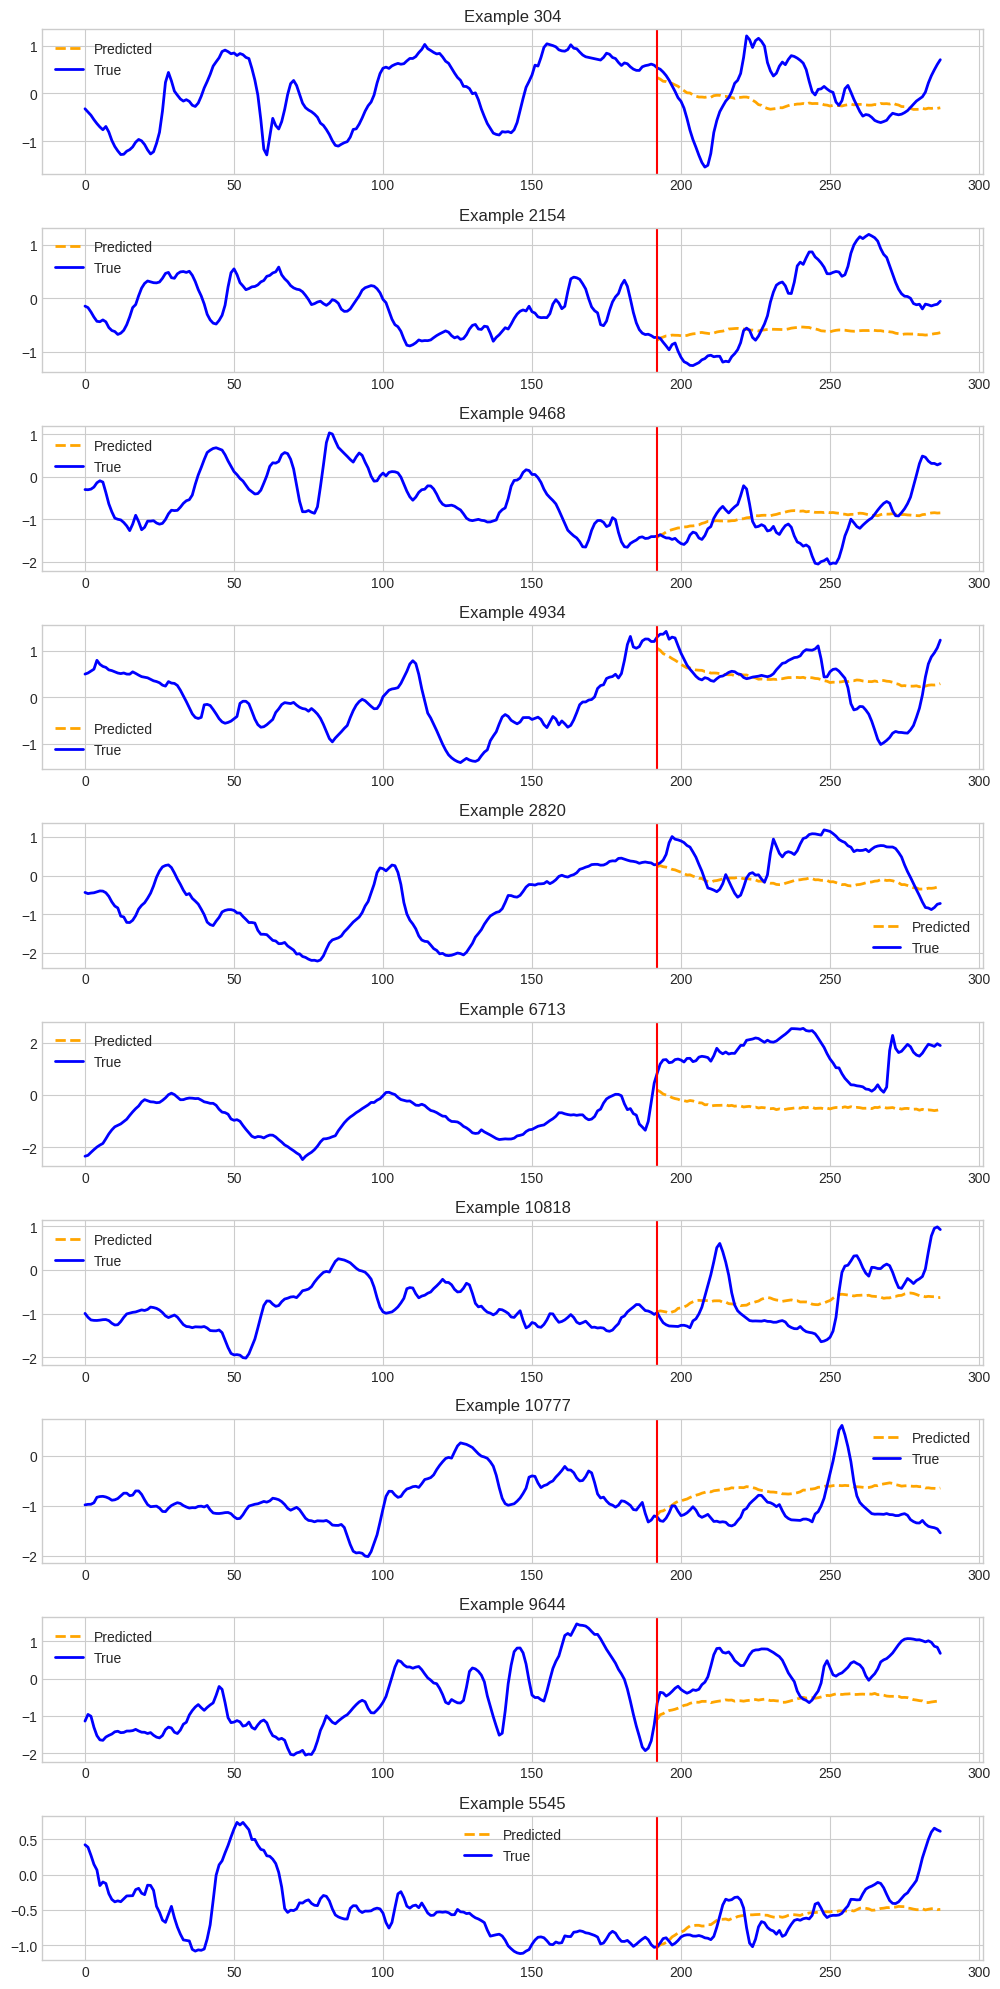

In [67]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_finetune",
    channel=0,
)